In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate

In [ ]:
df = pd.read_csv('output_data/modeling_data.csv', parse_dates=['datetime'])
pollutants = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']

In [59]:
def get_pollutant_X_y(pollutant, split_date = '2017-01-01 00:00',df = df):
    '''
    This function will separate the features and targets from the dataframe.
    '''

    features = [f'{pollutant}', f'{pollutant}_lag1', f'{pollutant}_lag2', f'{pollutant}_lag3', f'{pollutant}_rolling_6h', 'hour', 'day', 'weekend', 'month', 'year', 'TEMP', 'PRES', 'DEWP', 'WSPM', 'station_id']
    target = [f'{pollutant}_target']

    df.sort_values(['datetime', 'station_id'], ignore_index=True, inplace=True)

    train = df[df['datetime'] < split_date]
    test = df[df['datetime'] >= split_date]

    X_train = train[features]
    X_test = test[features]
    y_train = train[target]
    y_test = test[target]

    return X_train, X_test, y_train, y_test

In [79]:
X_train, X_test, y_train, y_test = get_pollutant_X_y('PM2.5')

In [83]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

model = xgb.XGBRegressor(
    tree_method='hist',
    n_estimators=200,
    learning_rate=1,
    max_depth=6,
    random_state=1
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [84]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(
        f'Mean Absolute Error:       {mae:.3f} \n'
        f'Root Mean Squared Error:   {rmse:.3f}'
)

Mean Absolute Error:       17.658 
Root Mean Squared Error:   37.442


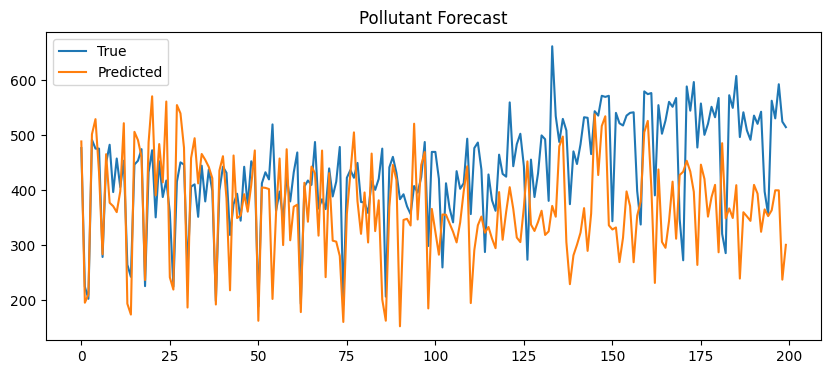

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(y_test.values[:200], label='True')
plt.plot(y_pred[:200], label='Predicted')
plt.legend()
plt.title('Pollutant Forecast')
plt.show()

In [51]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(
    n_splits=5,
    gap=48,
    test_size=5000)

In [42]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error']
    )
    mae = -cv_results['test_neg_mean_absolute_error']
    rmse = -cv_results['test_neg_root_mean_squared_error']
    print(
        f'Mean Absolute Error:       {mae.mean():.3f} +/- {mae.std():.3f}\n'
        f'Root Mean Squared Error:   {rmse.mean():.3f} +/- {rmse.std():.3f}'
    )

In [53]:
xgbR = xgb.XGBRegressor(
    tree_method='hist',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    objective='reg:squarederror',
    random_state=1
    )

evaluate(xgbR, X, y, tscv)

Mean Absolute Error:       14.908 +/- 3.887
Root Mean Squared Error:   27.043 +/- 6.575


In [58]:
X

,PM2.5,PM2.5_lag1,PM2.5_lag2,PM2.5_lag3,PM2.5_rolling_6h,hour,day,weekend,month,year,TEMP,PRES,DEWP,WSPM,station_id
0,5.0,3.0,6.0,7.0,5.500000,5,1,0,3,2013,-2.2,1025.6,-19.6,3.7,1
1,3.0,3.0,3.0,3.0,3.000000,5,1,0,3,2013,-4.5,1022.6,-19.5,1.7,2
2,6.0,5.0,6.0,5.0,5.500000,5,1,0,3,2013,-4.5,1022.6,-19.5,1.7,3
3,4.0,3.0,3.0,7.0,5.000000,5,1,0,3,2013,-2.4,1027.5,-21.3,2.4,4
4,3.0,3.0,3.0,3.0,3.333333,5,1,0,3,2013,-2.2,1025.6,-19.6,3.7,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420691,11.0,15.0,18.0,14.0,14.333333,22,28,0,2,2017,10.5,1014.4,-12.9,1.2,8
420692,18.0,18.0,47.0,27.0,22.666667,22,28,0,2,2017,7.1,1015.2,-13.2,1.8,9
420693,15.0,18.0,11.0,20.0,14.666667,22,28,0,2,2017,10.5,1014.4,-12.9,1.2,10
420694,12.0,13.0,15.0,11.0,11.333333,22,28,0,2,2017,7.8,1012.9,-12.6,1.0,11
